In [1]:
import numpy as np
import pickle

from reader import *
from encoder import *
import matplotlib.pyplot as plt
from utils import TunnelingStripifier, TriangleMesh

bunny_model = Reader.read_from_file('assets/stanford-bunny.obj')

baseline_encoder = BaselineEncoder()
baseline_compressed_model = baseline_encoder.encode(bunny_model)

# stripifier = TunnelingStripifier(TriangleMesh(bunny_model.vertices, bunny_model.triangles))
# stripifier.run(iters=60_000)
# with open('pickles/TunnelingStripifier(bunny_model).pkl', 'wb') as f:
#     pickle.dump(stripifier, f)
with open('pickles/TunnelingStripifier(bunny_model).pkl', 'rb') as f:
    stripifier = pickle.load(f)
strips = stripifier.extract_vertex_strips()
bunny_model.triangle_strips = strips
print(f"Before: {len(bunny_model.triangles)} strips, {len(bunny_model.triangles) * 3} verts")
print(f"After: {len(strips)} strips, {sum(len(s) for s in strips)} verts")


def print_statistics(compressed_model, name):
    print(f"{name} statistics:")
    print(f"- Bytes per triangle: {compressed_model.bits_per_triangle / 8:.2f}")
    print(f"- Bytes per vertex: {compressed_model.bits_per_vertex / 8:.2f}")
    print(f"- Compression rate: {baseline_compressed_model.bits_per_vertex / compressed_model.bits_per_vertex:.2f}")


print_statistics(baseline_compressed_model, "BaselineEncoder")


Before: 69451 strips, 208353 verts
After: 17163 strips, 103777 verts
BaselineEncoder statistics:
- Bytes per triangle: 18.21
- Bytes per vertex: 35.18
- Compression rate: 1.00


In [9]:
vertex_quantization_error = 0.0005
encoders = [
    (BaselineEncoder(), "BaselineEncoder", True),
    (
        SimpleQuantizator(pack_strip=Packing.NONE, pack_vertices=Packing.NONE,
                          vertex_quantization_error=vertex_quantization_error, verbose=True),
        f"SimpleQuantizator(pack_strip=Packing.NONE, pack_vertices=Packing.NONE, vertex_quantization_error={vertex_quantization_error})",
        True
    ),
    (
        SimpleQuantizator(pack_strip=Packing.RADIX_BINARY_TREE, pack_vertices=Packing.RADIX_BINARY_TREE,
                          vertex_quantization_error=vertex_quantization_error, verbose=True),
        f"SimpleQuantizator(pack_strip=Packing.FIXED, pack_vertices=Packing.RADIX_BINARY_TREE, vertex_quantization_error={vertex_quantization_error})",
        True
    ),
]

In [10]:
import os

compressed_models = []
for encoder, name, allow_use_cached in encoders:
    encoder_pickle_path = f'pickles/{name}_encoder(bunny_model).pkl'
    encoded_model_pickle_path = f'pickles/{name}_encoded_model(bunny_model).pkl'

    if allow_use_cached and os.path.exists(encoder_pickle_path):
        with open(encoder_pickle_path, 'rb') as f:
            encoder = pickle.load(f)
        with open(encoded_model_pickle_path, 'rb') as f:
            compressed_model = pickle.load(f)
    else:
        compressed_model = encoder.encode(bunny_model)
        with open(encoder_pickle_path, 'wb') as f:
            pickle.dump(encoder, f)
        with open(encoded_model_pickle_path, 'wb') as f:
            pickle.dump(compressed_model, f)
    print_statistics(compressed_model, name)
    compressed_models.append(compressed_model)

BaselineEncoder statistics:
- Bytes per triangle: 18.21
- Bytes per vertex: 35.18
- Compression rate: 1.00
SimpleQuantizator(pack_strip=Packing.NONE, pack_vertices=Packing.NONE, vertex_quantization_error=0.0005) statistics:
- Bytes per triangle: 16.14
- Bytes per vertex: 31.19
- Compression rate: 1.13
SimpleQuantizator(pack_strip=Packing.FIXED, pack_vertices=Packing.RADIX_BINARY_TREE, vertex_quantization_error=0.0005) statistics:
- Bytes per triangle: 6.81
- Bytes per vertex: 13.16
- Compression rate: 2.67


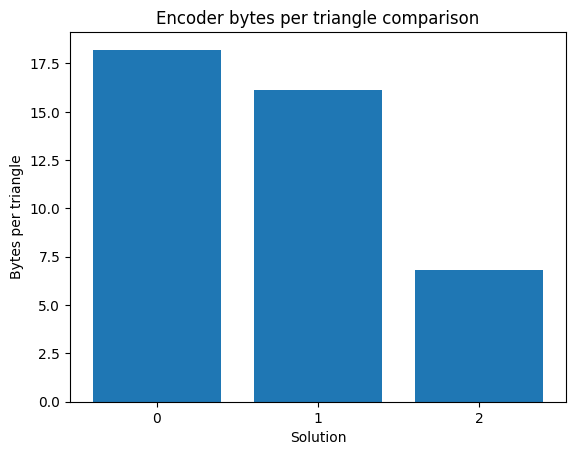

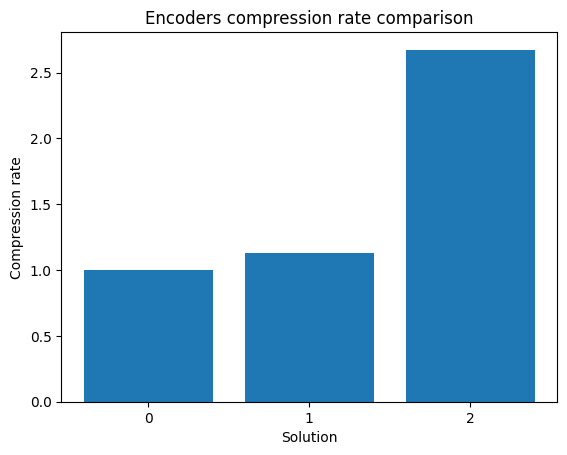

In [11]:
def show_and_save_bar_plots(compressed_models: List[CompressedModel]):
    bytes_per_triangle = [model.bits_per_triangle / 8 for model in compressed_models]
    compression_rate = [baseline_compressed_model.bits_per_vertex / model.bits_per_vertex for model in
                        compressed_models]

    # Create the histogram
    plt.bar(list(range(len(bytes_per_triangle))), bytes_per_triangle)

    # Add title and labels
    plt.title('Encoder bytes per triangle comparison')
    plt.xlabel('Solution')
    plt.xticks(list(range(len(bytes_per_triangle))))
    plt.ylabel('Bytes per triangle')

    # Save the histogram as an image
    plt.savefig('images/bytes_per_triangle_bar_plot.png')  # Save as PNG file
    plt.show()  # Display the plot

    # Create the histogram
    plt.bar(list(range(len(compression_rate))), compression_rate)

    # Add title and labels
    plt.title('Encoders compression rate comparison')
    plt.xlabel('Solution')
    plt.xticks(list(range(len(compression_rate))))
    plt.ylabel('Compression rate')

    # Save the histogram as an image
    plt.savefig('images/compression_rate_bar_plot.png')  # Save as PNG file
    plt.show()  # Display the plot


show_and_save_bar_plots(compressed_models)

BaselineEncoder statistics:
- Bytes per triangle: 18.21
- Bytes per vertex: 35.18
- Compression rate: 1.00


In [3]:
# stripifier = TunnelingStripifier(TriangleMesh(bunny_model.vertices, bunny_model.triangles))

In [4]:
# stripifier.run(iters=60_000)

 87%|████████▋ | 52288/60000 [10:12<01:30, 85.36it/s] 


In [5]:
# import pickle
# with open('pickles/TunnelingStripifier(bunny_model).pkl', 'wb') as f:
#     pickle.dump(stripifier, f)

In [7]:
with open('pickles/TunnelingStripifier(bunny_model).pkl', 'rb') as f:
    stripifier = pickle.load(f)

In [9]:
strips = loaded.extract_vertex_strips()

In [ ]:
strips

In [10]:
print(f"Before: {len(bunny_model.triangles)} strips, {len(bunny_model.triangles) * 3} verts")
print(f"After: {len(strips)} strips, {sum(len(s) for s in strips)} verts")

Before: 69451 strips, 208353 verts
After: 17163 strips, 103777 verts


In [3]:
simple_ellipsoid_fitter_encoder = SimpleEllipsoidFitter(pack_strip=Packing.RADIX_BINARY_TREE,
                                                        vertex_quantization_error=0.0005,
                                                        max_hierarchical_fitting_depth=3,
                                                        verbose=True)
simple_ellipsoid_fitter_encoder_compressed_model = simple_ellipsoid_fitter_encoder.encode(
    bunny_model.copy())

print_statistics(simple_ellipsoid_fitter_encoder_compressed_model,
                 "SimpleEllipsoidFitter(0.0005, 3)")

KeyboardInterrupt: 

In [6]:
simple_ellipsoid_fitter_encoder4 = SimpleEllipsoidFitter(pack_strip=Packing.RADIX_BINARY_TREE,
                                                         vertex_quantization_error=0.0005,
                                                         max_hierarchical_fitting_depth=4,
                                                         verbose=True)
simple_ellipsoid_fitter_encoder4_compressed_model = simple_ellipsoid_fitter_encoder4.encode(
    bunny_model.copy())

print_statistics(simple_ellipsoid_fitter_encoder4_compressed_model,
                 "SimpleEllipsoidFitter(0.0005, 4)")

SimpleEllipsoidFitter verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 11.145
- Triangles strip average code bit length: 11.363
- Triangles strip (in bytes): 16456
- Quantized vertices average code bit length: 13.395
- Quantized vertices (in bytes): 4191
SimpleEllipsoidFitter(0.0005, 4) statistics:
- Bytes per triangle: 4.16
- Bytes per vertex: 8.26
- Compression rate: 4.34


In [7]:
packed_gts_ellipsoid_fitter_encoder = PackedGTSEllipsoidFitter(pack_strip=Packing.RADIX_BINARY_TREE,
                                                               vertex_quantization_error=0.0005,
                                                               max_hierarchical_fitting_depth=3,
                                                               verbose=True)
packed_gts_ellipsoid_fitter_compressed_model = packed_gts_ellipsoid_fitter_encoder.encode(
    bunny_model.copy())

print_statistics(packed_gts_ellipsoid_fitter_compressed_model,
                 "PackedGTSEllipsoidFitter(0.0005, 3)")

PackedGTSEllipsoidFitter verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 9.708
- Triangles strip (in bytes): 9458
- Quantized vertices average code bit length: 16.205
- Quantized vertices (in bytes): 5070
PackedGTSEllipsoidFitter(0.0005, 3) statistics:
- Bytes per triangle: 2.93
- Bytes per vertex: 5.82
- Compression rate: 6.16


In [8]:
packed_gts_ellipsoid_fitter4_encoder = PackedGTSEllipsoidFitter(pack_strip=Packing.RADIX_BINARY_TREE,
                                                                vertex_quantization_error=0.0005,
                                                                max_hierarchical_fitting_depth=4,
                                                                verbose=True)
packed_gts_ellipsoid_fitter4_compressed_model = packed_gts_ellipsoid_fitter4_encoder.encode(
    bunny_model.copy())

print_statistics(packed_gts_ellipsoid_fitter4_compressed_model,
                 "PackedGTSEllipsoidFitter(0.0005, 4)")

PackedGTSEllipsoidFitter verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 9.708
- Triangles strip (in bytes): 9458
- Quantized vertices average code bit length: 13.402
- Quantized vertices (in bytes): 4193
PackedGTSEllipsoidFitter(0.0005, 4) statistics:
- Bytes per triangle: 2.75
- Bytes per vertex: 5.47
- Compression rate: 6.55


In [4]:
gts_parallelogram_predictor_huffman_encoder = GTSParallelogramPredictor(pack_strip=Packing.RADIX_BINARY_TREE,
                                                                        entropy_encoder_type=Packing.HUFFMAN_ENCODER,
                                                                        enable_entropy_encoder_conditional_probabilities=False,
                                                                        verbose=True)
gts_parallelogram_predictor_huffman_encoder_compressed_model = gts_parallelogram_predictor_huffman_encoder.encode(
    bunny_model)

print_statistics(gts_parallelogram_predictor_huffman_encoder_compressed_model,
                 "GTSParallelogramPredictor(Huffman encoder)")

KeyError: 34834

In [13]:
gts_parallelogram_predictor_adaptive_huffman_encoder = GTSParallelogramPredictor(
    pack_strip=Packing.RADIX_BINARY_TREE,
    entropy_encoder_type=Packing.HUFFMAN_ENCODER,
    enable_entropy_encoder_conditional_probabilities=True,
    verbose=True)
gts_parallelogram_predictor_adaptive_huffman_encoder_compressed_model = gts_parallelogram_predictor_adaptive_huffman_encoder.encode(
    bunny_model)

print_statistics(gts_parallelogram_predictor_adaptive_huffman_encoder_compressed_model,
                 "GTSParallelogramPredictor(adaptive Huffman encoder)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 9.708
- Triangles strip (in bytes): 9458
- Quantized vertices entropy: 4.997038737229633
- Quantized vertices average code bit length: 5.118
- Quantized vertices (in bytes): 14960
GTSParallelogramPredictor(adaptive Huffman encoder) statistics:
- Bytes per triangle: 4.92
- Bytes per vertex: 9.77
- Compression rate: 3.67


In [14]:
gts_parallelogram_predictor_arithmetic_encoder = GTSParallelogramPredictor(pack_strip=Packing.RADIX_BINARY_TREE,
                                                                           entropy_encoder_type=Packing.ARITHMETIC_ENCODER,
                                                                           enable_entropy_encoder_conditional_probabilities=False,
                                                                           verbose=True)
gts_parallelogram_predictor_arithmetic_encoder_compressed_model = gts_parallelogram_predictor_arithmetic_encoder.encode(
    bunny_model)

print_statistics(gts_parallelogram_predictor_arithmetic_encoder_compressed_model,
                 "GTSParallelogramPredictor(arithmetic encoder)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 9.708
- Triangles strip (in bytes): 9458


100%|██████████| 23383/23383 [00:00<00:00, 191491.82it/s]

- Quantized vertices entropy: 4.997038737229633
- Quantized vertices average code bit length: 5.123
- Quantized vertices (in bytes): 14973
GTSParallelogramPredictor(arithmetic encoder) statistics:
- Bytes per triangle: 4.92
- Bytes per vertex: 9.77
- Compression rate: 3.67


In [15]:
gts_parallelogram_predictor_adaptive_arithmetic_encoder = GTSParallelogramPredictor(
    pack_strip=Packing.RADIX_BINARY_TREE,
    entropy_encoder_type=Packing.ARITHMETIC_ENCODER,
    enable_entropy_encoder_conditional_probabilities=True,
    verbose=True)
gts_parallelogram_predictor_adaptive_arithmetic_encoder_compressed_model = gts_parallelogram_predictor_adaptive_arithmetic_encoder.encode(
    bunny_model)

print_statistics(gts_parallelogram_predictor_adaptive_arithmetic_encoder_compressed_model,
                 "GTSParallelogramPredictor(adaptive arithmetic encoder)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 9.708
- Triangles strip (in bytes): 9458


100%|██████████| 23383/23383 [00:00<00:00, 27419.90it/s]

- Quantized vertices entropy: 4.997038737229633
- Quantized vertices average code bit length: 5.089
- Quantized vertices (in bytes): 14875
GTSParallelogramPredictor(adaptive arithmetic encoder) statistics:
- Bytes per triangle: 4.90
- Bytes per vertex: 9.73
- Compression rate: 3.68


In [16]:
packed_gts_encoder_radix_binary_tree_packing = PackedGTSQuantizator(pack_strip=Packing.RADIX_BINARY_TREE,
                                                                    verbose=True)
packed_gts_encoder_radix_binary_tree_packing_compressed_model = packed_gts_encoder_radix_binary_tree_packing.encode(
    bunny_model)

print_statistics(packed_gts_encoder_radix_binary_tree_packing_compressed_model,
                 "PackedGTSQuantizator(radix binary tree packing)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 9.708
- Triangles strip (in bytes): 9458
- Quantized vertices entropy: 11.520605177332085
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
PackedGTSQuantizator(radix binary tree packing) statistics:
- Bytes per triangle: 4.18
- Bytes per vertex: 8.29
- Compression rate: 4.32


In [17]:
encoder_no_packing = SimpleQuantizator(pack_strip=Packing.NONE, verbose=True)
encoder_no_packing_compressed_model = encoder_no_packing.encode(bunny_model)

print_statistics(encoder_no_packing_compressed_model, "SimpleQuantizator(no packing)")

SimpleQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 11.145
- Triangles strip average code bit length: 32.000
- Triangles strip (in bytes): 46344
- Quantized vertices entropy: 11.52060517733206
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
SimpleQuantizator(no packing) statistics:
- Bytes per triangle: 11.60
- Bytes per vertex: 23.03
- Compression rate: 1.56


In [18]:
encoder_fixed_packing = SimpleQuantizator(pack_strip=Packing.FIXED, verbose=True)
encoder_fixed_packing_model = encoder_fixed_packing.encode(bunny_model)

print_statistics(encoder_fixed_packing_model, "SimpleQuantizator(fixed packing)")

SimpleQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 11.145
- Triangles strip average code bit length: 12.000
- Triangles strip (in bytes): 17379
- Quantized vertices entropy: 11.52060517733206
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
SimpleQuantizator(fixed packing) statistics:
- Bytes per triangle: 5.77
- Bytes per vertex: 11.46
- Compression rate: 3.13


In [19]:
encoder_binary_range_partitioning_packing = SimpleQuantizator(pack_strip=Packing.BINARY_RANGE_PARTITIONING,
                                                              verbose=True)
encoder_binary_range_partitioning_packing_compressed_model = encoder_binary_range_partitioning_packing.encode(
    bunny_model)

print_statistics(encoder_binary_range_partitioning_packing_compressed_model,
                 "SimpleQuantizator(binary range partitioning packing)")

SimpleQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 11.145
- Triangles strip average code bit length: 11.709
- Triangles strip (in bytes): 16958
- Quantized vertices entropy: 11.52060517733206
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
SimpleQuantizator(binary range partitioning packing) statistics:
- Bytes per triangle: 5.69
- Bytes per vertex: 11.29
- Compression rate: 3.17


In [20]:
encoder_binary_range_partitioning_packing = SimpleQuantizator(pack_strip=Packing.BINARY_RANGE_PARTITIONING,
                                                              allow_reorder=True, verbose=True)
encoder_binary_range_partitioning_packing_compressed_model = encoder_binary_range_partitioning_packing.encode(
    bunny_model)

print_statistics(encoder_binary_range_partitioning_packing_compressed_model,
                 "SimpleQuantizator(binary range partitioning packing, reordered)")

SimpleQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 11.145
- Triangles strip average code bit length: 11.465
- Triangles strip (in bytes): 16604
- Quantized vertices entropy: 11.520605177332088
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
SimpleQuantizator(binary range partitioning packing, reordered) statistics:
- Bytes per triangle: 5.62
- Bytes per vertex: 11.15
- Compression rate: 3.21


In [21]:
encoder_radix_binary_tree_packing = SimpleQuantizator(pack_strip=Packing.RADIX_BINARY_TREE, verbose=True)
encoder_radix_binary_tree_packing_compressed_model = encoder_radix_binary_tree_packing.encode(bunny_model)

print_statistics(encoder_radix_binary_tree_packing_compressed_model, "SimpleQuantizator(radix binary tree packing)")

SimpleQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 11.145
- Triangles strip average code bit length: 11.363
- Triangles strip (in bytes): 16456
- Quantized vertices entropy: 11.52060517733206
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
SimpleQuantizator(radix binary tree packing) statistics:
- Bytes per triangle: 5.59
- Bytes per vertex: 11.09
- Compression rate: 3.23


In [22]:
encoder_radix_binary_tree_packing = SimpleQuantizator(pack_strip=Packing.RADIX_BINARY_TREE, allow_reorder=True,
                                                      verbose=True)
encoder_radix_binary_tree_packing_compressed_model = encoder_radix_binary_tree_packing.encode(bunny_model)

print_statistics(encoder_radix_binary_tree_packing_compressed_model,
                 "SimpleQuantizator(radix binary tree packing, reordered)")

SimpleQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 11.145
- Triangles strip average code bit length: 11.208
- Triangles strip (in bytes): 16232
- Quantized vertices entropy: 11.5206051773321
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
SimpleQuantizator(radix binary tree packing, reordered) statistics:
- Bytes per triangle: 5.54
- Bytes per vertex: 11.00
- Compression rate: 3.26


In [23]:
gts_encoder_fixed_packing = GTSQuantizator(pack_strip=Packing.FIXED, verbose=True)
gts_encoder_fixed_packing_compressed_model = gts_encoder_fixed_packing.encode(bunny_model)

print_statistics(gts_encoder_fixed_packing_compressed_model, "GTSQuantizator(fixed packing)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.132
- Triangles strip average code bit length: 13.000
- Triangles strip (in bytes): 12665
- Quantized vertices entropy: 11.52060517733206
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
GTSQuantizator(fixed packing) statistics:
- Bytes per triangle: 4.82
- Bytes per vertex: 9.57
- Compression rate: 3.74


In [24]:
gts_encoder_radix_binary_tree_packing = GTSQuantizator(pack_strip=Packing.RADIX_BINARY_TREE, verbose=True)
gts_encoder_radix_binary_tree_packing_compressed_model = gts_encoder_radix_binary_tree_packing.encode(bunny_model)

print_statistics(gts_encoder_radix_binary_tree_packing_compressed_model, "GTSQuantizator(radix binary tree packing)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.132
- Triangles strip average code bit length: 12.355
- Triangles strip (in bytes): 12037
- Quantized vertices entropy: 11.52060517733206
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
GTSQuantizator(radix binary tree packing) statistics:
- Bytes per triangle: 4.70
- Bytes per vertex: 9.32
- Compression rate: 3.84


In [25]:
packed_gts_encoder_fixed_packing = PackedGTSQuantizator(pack_strip=Packing.FIXED, verbose=True)
packed_gts_encoder_fixed_packing_compressed_model = packed_gts_encoder_fixed_packing.encode(bunny_model)

print_statistics(packed_gts_encoder_fixed_packing_compressed_model, "PackedGTSQuantizator(fixed packing)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 10.146
- Triangles strip (in bytes): 9885
- Quantized vertices entropy: 11.520605177332085
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
PackedGTSQuantizator(fixed packing) statistics:
- Bytes per triangle: 4.26
- Bytes per vertex: 8.46
- Compression rate: 4.23


In [26]:
packed_gts_encoder_radix_binary_tree_packing = PackedGTSQuantizator(pack_strip=Packing.RADIX_BINARY_TREE,
                                                                    verbose=True)
packed_gts_encoder_radix_binary_tree_packing_compressed_model = packed_gts_encoder_radix_binary_tree_packing.encode(
    bunny_model)

print_statistics(packed_gts_encoder_radix_binary_tree_packing_compressed_model,
                 "PackedGTSQuantizator(radix binary tree packing)")

GTSQuantizator verbose statistics:
- Header (in bytes): 32
- Triangles strip entropy: 12.822
- Triangles strip average code bit length: 9.708
- Triangles strip (in bytes): 9458
- Quantized vertices entropy: 11.520605177332085
- Quantized vertices average code bit length: 12.002
- Quantized vertices (in bytes): 11265
PackedGTSQuantizator(radix binary tree packing) statistics:
- Bytes per triangle: 4.18
- Bytes per vertex: 8.29
- Compression rate: 4.32


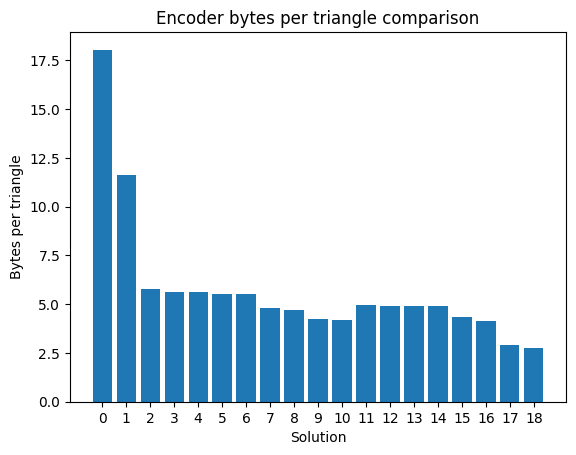

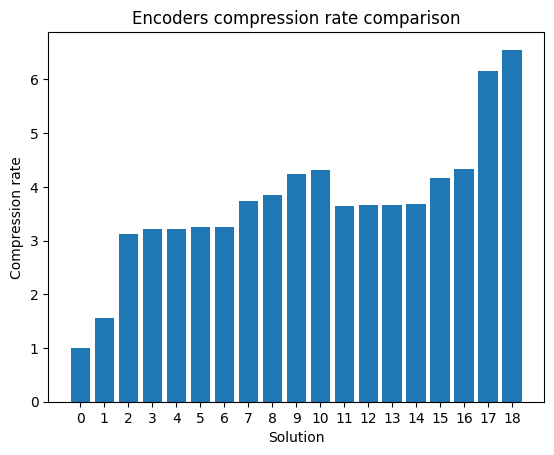

In [27]:

def show_and_save_bar_plots(compressed_models: List[CompressedModel]):
    bytes_per_triangle = [model.bits_per_triangle / 8 for model in compressed_models]
    compression_rate = [baseline_compressed_model.bits_per_vertex / model.bits_per_vertex for model in
                        compressed_models]

    # Create the histogram
    plt.bar(list(range(len(bytes_per_triangle))), bytes_per_triangle)

    # Add title and labels
    plt.title('Encoder bytes per triangle comparison')
    plt.xlabel('Solution')
    plt.xticks(list(range(len(bytes_per_triangle))))
    plt.ylabel('Bytes per triangle')

    # Save the histogram as an image
    plt.savefig('images/bytes_per_triangle_bar_plot.png')  # Save as PNG file
    plt.show()  # Display the plot

    # Create the histogram
    plt.bar(list(range(len(compression_rate))), compression_rate)

    # Add title and labels
    plt.title('Encoders compression rate comparison')
    plt.xlabel('Solution')
    plt.xticks(list(range(len(compression_rate))))
    plt.ylabel('Compression rate')

    # Save the histogram as an image
    plt.savefig('images/compression_rate_bar_plot.png')  # Save as PNG file
    plt.show()  # Display the plot


show_and_save_bar_plots([baseline_compressed_model, encoder_no_packing_compressed_model, encoder_fixed_packing_model,
                         encoder_binary_range_partitioning_packing_compressed_model,
                         encoder_binary_range_partitioning_packing_compressed_model,
                         encoder_radix_binary_tree_packing_compressed_model,
                         encoder_radix_binary_tree_packing_compressed_model, gts_encoder_fixed_packing_compressed_model,
                         gts_encoder_radix_binary_tree_packing_compressed_model,
                         packed_gts_encoder_fixed_packing_compressed_model,
                         packed_gts_encoder_radix_binary_tree_packing_compressed_model,
                         gts_parallelogram_predictor_huffman_encoder_compressed_model,
                         gts_parallelogram_predictor_adaptive_huffman_encoder_compressed_model,
                         gts_parallelogram_predictor_arithmetic_encoder_compressed_model,
                         gts_parallelogram_predictor_adaptive_arithmetic_encoder_compressed_model,
                         simple_ellipsoid_fitter_encoder_compressed_model,
                         simple_ellipsoid_fitter_encoder4_compressed_model,
                         packed_gts_ellipsoid_fitter_compressed_model,
                         packed_gts_ellipsoid_fitter4_compressed_model,
                         ])